# Intra-frame main analysis

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [42]:
# External packages
import os
import jupyter_slack
import datetime

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer

# Root directory for output figures
figsdir = get_data_root(kind=DataRoot.FIG)  
logger.info(f'output figures directory: "{figsdir}"')

# Figures dictionary
figs = {}

 2025/07/10 18:30:54: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs"


### Input datasets and main processing parameters

In [43]:
analysis_type = 'main'  # Analysis type
mouseline = 'line3'
slack_notify = False

### Derived parameters

In [44]:
group_key, group_refval = {  # Grouping variable and reference value for the analysis
    'main': (Label.ISPTA, 0.),
    'offset': (Label.OFFSET, 2.0),
}[analysis_type]
refcolor = Palette.LINE[mouseline] # Reference color for the plot

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseline} {analysis_type} intraframe analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/07/10 18:30:56: line3 main intraframe analysis notebook started on 2025-07-10 at 18:30:56


### Load and organize data

In [45]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# For each input file
trialagg_dFF, info_table = {}, {}
for fname in datafiles:
    # Parse dataset ID from file name
    dataset_ID = os.path.splitext(fname)[0]
    
    # Load dFF data and info table
    dFF, table = load_rowavg_dataset(os.path.join(datadir, fname))
    
    # If no baseline data, skip this dataset
    if group_key == Label.ISPTA and not any(table[Label.P] == 0.):
        logger.warning(f'no data for P = 0 in {dataset_ID} -> skipping')
        continue
    
    # Restrict data to non-duplicated runs
    codefunc = get_param_code if group_key == Label.ISPTA else get_offset_code
    iruns = codefunc(table).drop_duplicates(keep='first').index.values
    table = table.loc[iruns]
    mux_slice = get_mux_slice(dFF.index)
    mux_slice[0] = iruns
    dFF = dFF.loc[tuple(mux_slice)]

    # Average dFF data across trials, and add to dictionary
    logger.info('computing trial-average dFF profiles')
    info_table[dataset_ID] = table
    trialagg_dFF[dataset_ID] = dFF.groupby([Label.RUN, Label.FRAME, Label.ROW]).mean()

# Assemble trial-average dFF profiles into multi-indexed pandas Series
logger.info(f'assembling {len(trialagg_dFF)} datasets into single multi-indexed series')
trialagg_dFF = pd.concat(trialagg_dFF, axis=0, names=[Label.DATASET])

# Assemble info table into single DataFrame
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET])

# Extract constant parameters from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
npulses = int(dur * PRF)

# Add relevant columns to info table
if group_key == Label.ISPTA:
    # For main analysis, add ISPTA and ISPPA columns
    info_table = add_intensity_to_table(info_table, precision=2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.P, Label.DC, Label.ISPPA, group_key]

elif group_key == Label.OFFSET:
    # For offset analysis, add transducer XY coordinates and offsets
    logger.info('parsing transducer XY offset coordinates...')
    offsets_2d = get_offset_complex(info_table)
    info_table['xoff (mm)'] = offsets_2d.apply(np.real)
    info_table['yoff (mm)'] = offsets_2d.apply(np.imag)
    xykeys = ['xoff (mm)', 'yoff (mm)']
    info_table[Label.OFFSET] = np.linalg.norm(info_table[xykeys], axis=1).round(2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.SUFFIX, *xykeys, group_key]

# Extract stimulus onset time from info table, and construct FrameIndexer
tref = get_stim_onset_time(mouseline)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial)
expfidx = fidx.resample(lpf)

# Subtract pre-stimulus baseline levels for each dataset and run
logger.info('subtracting pre-stimulus baseline levels')
gby = [Label.DATASET, Label.RUN]
def subtract_baseline(y):
    y0 = y.droplevel(gby).loc[:fidx.iref].median()
    return y - y0
trialagg_dFF = trialagg_dFF.groupby([Label.DATASET, Label.RUN]).transform(subtract_baseline)

# Add relevant columns to trialagg_dFF
trialagg_dFF = free_expand_and_add(info_table[exp_keys], trialagg_dFF.to_frame())

# Remove data for DC = 1%, if present
if Label.DC in trialagg_dFF.columns:
    logger.info('removing data for DC = 1%')
    trialagg_dFF = trialagg_dFF[trialagg_dFF[Label.DC] != 1.0]

# Create a mapping from grouping variable to DC
col_DC_map = info_table.groupby(group_key).first()[Label.DC]
if group_key == Label.ISPTA:  # Set DC = 0 for ISPTA = 0
    col_DC_map.loc[0.] = 0. 

# # Add serialized "frame-row" index column to trialagg_dFF
logger.info('adding serialized "frame-row" index column')
iframe = trialagg_dFF.index.get_level_values(Label.FRAME)
irow = trialagg_dFF.index.get_level_values(Label.ROW)
trialagg_dFF[Label.FRAMEROW] = iframe * lpf + irow

# Add time vector to trial-aggregated dFF
add_time_to_table(trialagg_dFF, fidx=expfidx, idxkey=Label.FRAMEROW, fps=fps * lpf)

trialagg_dFF

 2025/07/10 18:30:57: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/line3
 2025/07/10 18:30:57: loading row-average dFF data from 20191107_mouse1_region1.h5
 2025/07/10 18:30:58: loading experiment info table...
 2025/07/10 18:30:58: computing trial-average dFF profiles
 2025/07/10 18:30:59: loading row-average dFF data from 20191113_mouse9_region2.h5
 2025/07/10 18:30:59: loading experiment info table...
 2025/07/10 18:30:59: computing trial-average dFF profiles
 2025/07/10 18:31:00: loading row-average dFF data from 20191108_mouse6_region2.h5
 2025/07/10 18:31:00: loading experiment info table...
 2025/07/10 18:31:00: computing trial-average dFF profiles
 2025/07/10 18:31:00: loading row-average dFF data from 20200313_mouse14_region1.h5
 2025/07/10 18:31:00: loading experiment info table...
 2025/07/10 18:31:00: computing trial-average dFF profiles
 2025/07/10 18:31:01: loading row-average dFF data from 20191024_mouse5_region1.h5
 2025/07/10 18:31:01: loading 

ΔF/F0  P (MPa)  DC (%)  \
dataset                 run frame row                              
20191107_mouse1_region1 0   0     0   -0.056691      0.8    50.0   
                                  1   -0.050022      0.8    50.0   
                                  2   -0.049279      0.8    50.0   
                                  3   -0.048268      0.8    50.0   
                                  4   -0.040279      0.8    50.0   
...                                         ...      ...     ...   
20191108_mouse6_region1 14  99    251 -0.010605      0.0    50.0   
                                  252 -0.000670      0.0    50.0   
                                  253 -0.001163      0.0    50.0   
                                  254 -0.005264      0.0    50.0   
                                  255 -0.015320      0.0    50.0   

                                       I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
dataset                 run frame row                                   
20191107_mouse1_region1 0   0     0             19.78            9.89   
                                  1             19.78            9.89   
                                  2             19.78            9.89   
                                  3             19.78            9.89   
                                  4             19.78            9.89   
...                                               ...             ...   
20191108_mouse6_region1 14  99    251            0.00            0.00   
                                  252            0.00            0.00   
                                  253            0.00            0.00   
                                  254            0.00            0.00   
                                  255            0.00            0.00   

                                       frame row   time (s)  
dataset                 run frame row                        
20191107_mouse1_region1 0   0     0            0  -2.808989  
                                  1            1  -2.807892  
                                  2            2  -2.806794  
                                  3            3  -2.805697  
                                  4            4  -2.804600  
...                                          ...        ...  
20191108_mouse6_region1 14  99    251      25595  25.275413  
                                  252      25596  25.276510  
                                  253      25597  25.277607  
                                  254      25598  25.278704  
                                  255      25599  25.279802  

[8422400 rows x 7 columns]

### Define plot parameters

In [46]:
# Restrict time bounds for plotting 
tbounds = {
    'default': (-1, 5),  # Default time bounds
    'zoomed': (-0.1, 0.3)  # Time bounds around stimulus
}

# Common plot parameters
pltkwargs = {
    'col': group_key,
    'col_DC_mapper': col_DC_map,
    'stimdur': dur,
    'stimPRF': PRF,
    'fps': fps,
    'stimdelay': STIM_TRIG_DELAY,
}

### Plot trial-aggregated dFF vs grouping variable, across datasets (default and zoom-in around stimulus)

 2025/07/10 18:49:14: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.005 and 0.03 s


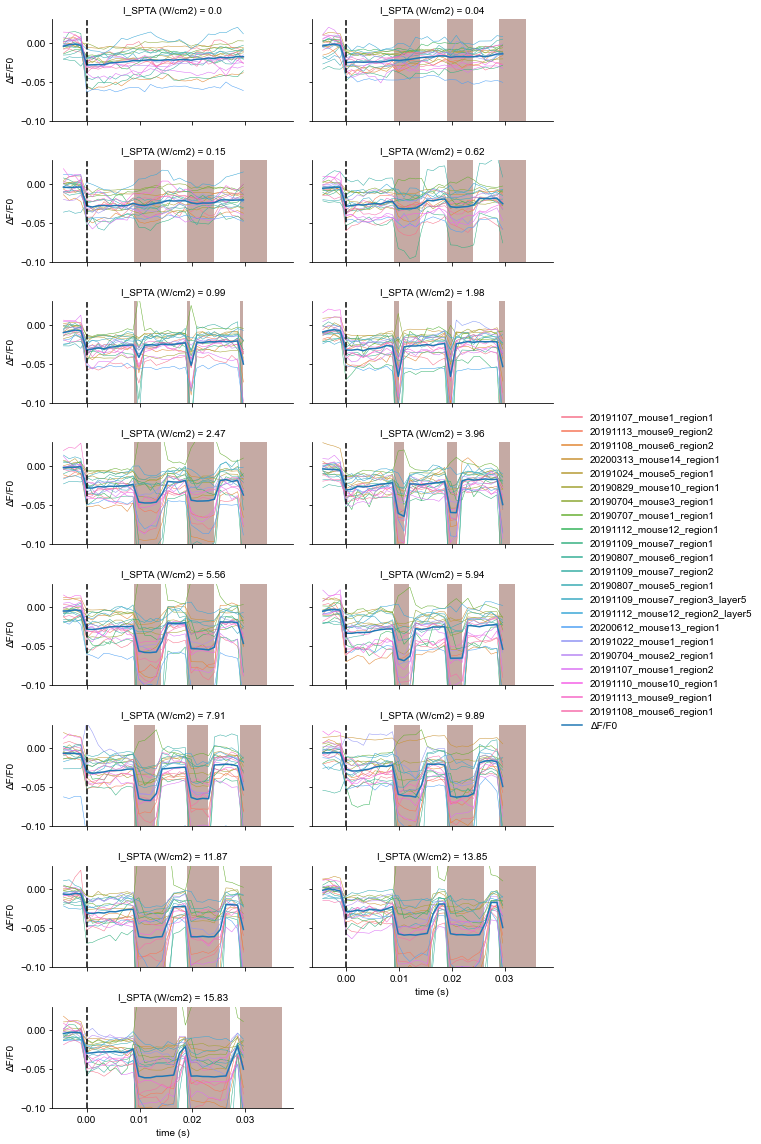

In [54]:
fig = plot_rowagg_profiles(
    trialagg_dFF.copy(),#[['20191108_mouse6_region1', '20191112_mouse12_region1']],
    tbounds=(-0.005, 0.03),
    hue=Label.DATASET,
    color=refcolor,
    aspect=2,
    **pltkwargs
)
for ax in fig.axes:
    ax.set_ylim(-0.1, 0.03)
fig.savefig('tmp.pdf')

 2025/07/10 18:09:53: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/10 18:10:21: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


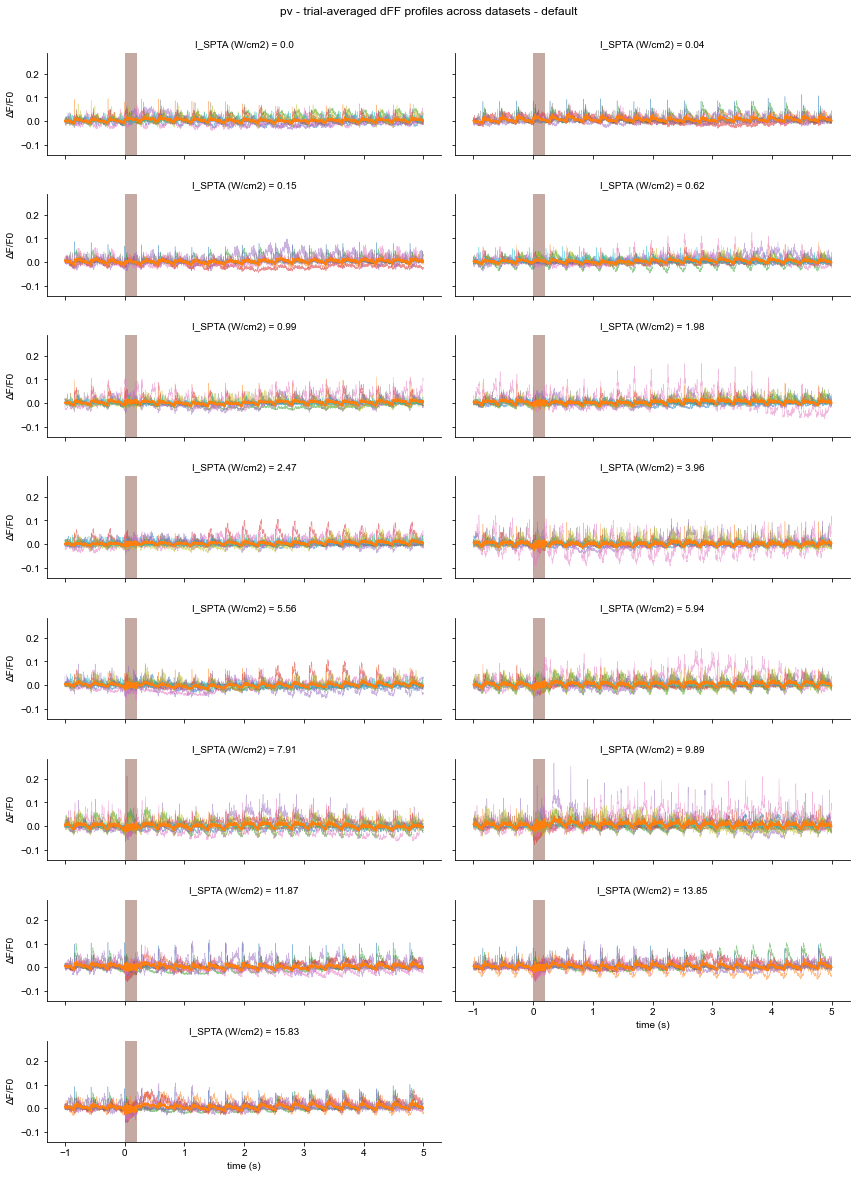

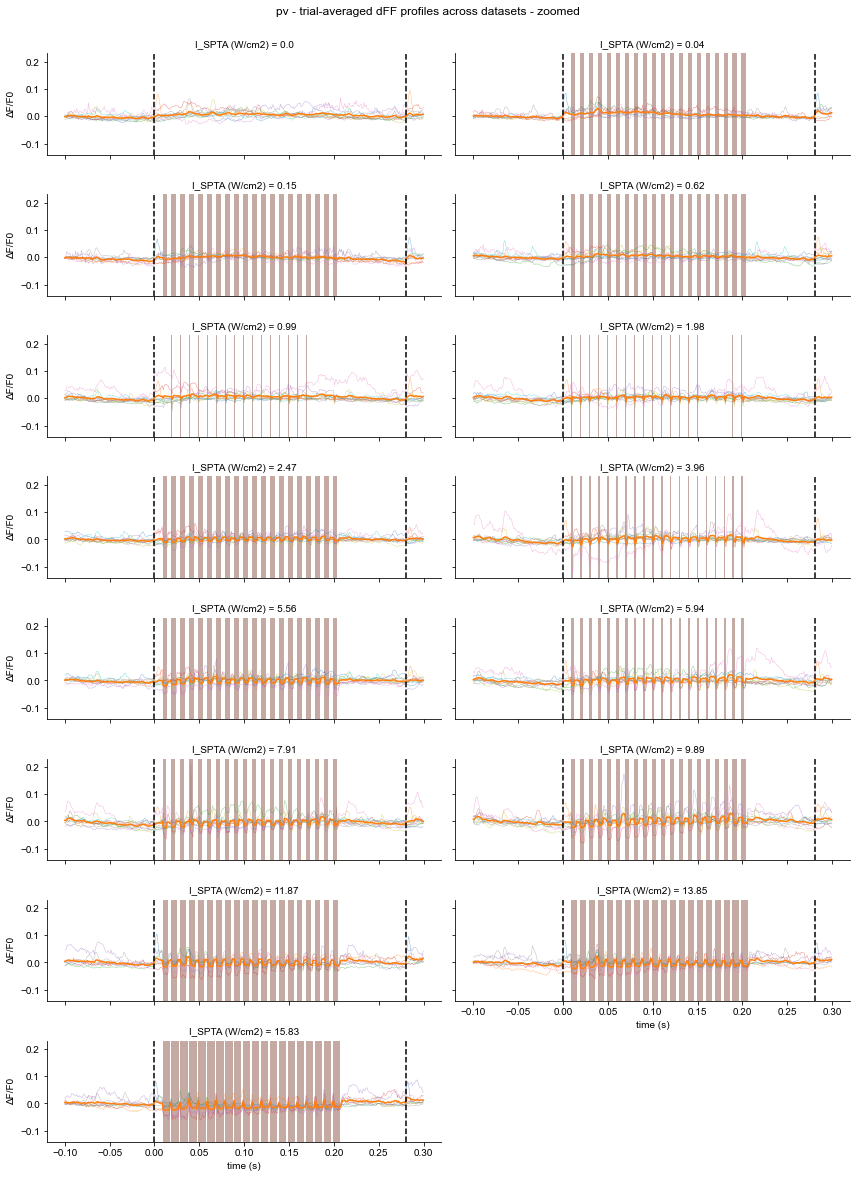

In [30]:
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles across datasets - {k}'
    figs[title] = plot_rowagg_profiles(
        trialagg_dFF.copy(), tbounds=v, hue=Label.DATASET, color=refcolor, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

### Show only cross-dataset average

 2025/07/10 18:10:29: computing cross-dataset aggregates
 2025/07/10 18:10:29: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/10 18:10:31: computing cross-dataset aggregates
 2025/07/10 18:10:32: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


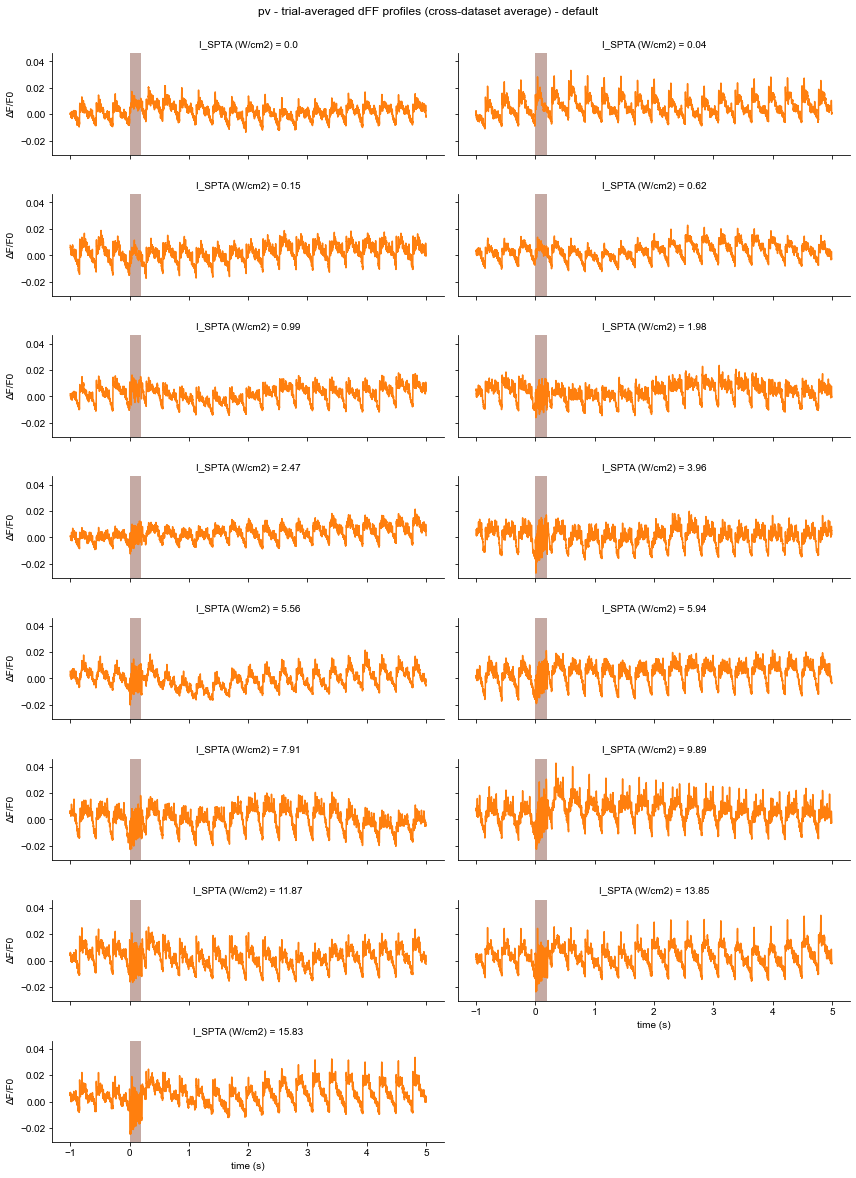

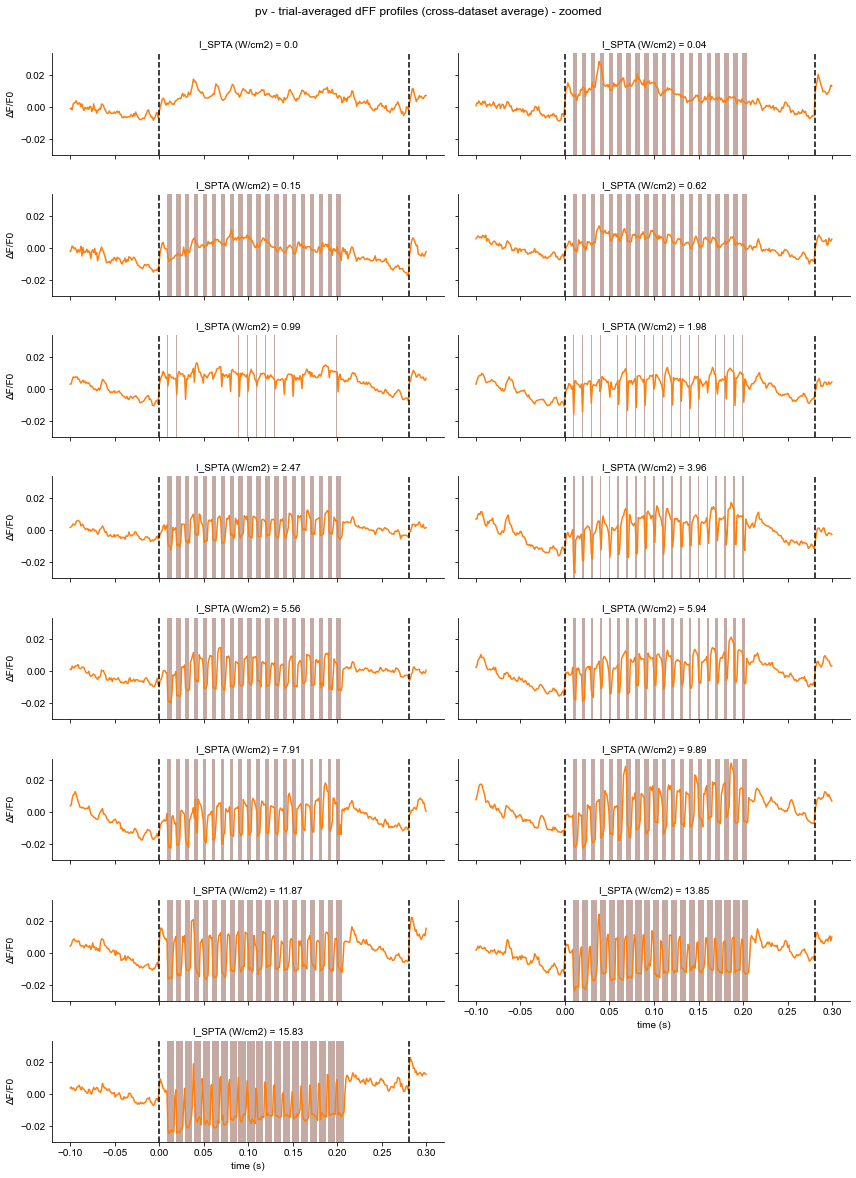

In [31]:
# Define function to aggregate across datasets
def aggregate_across_datasets(data):
    '''
    Aggregate across datasets by averaging dFF columns and 
    keeping first values for other columns.
    '''
    logger.info('computing cross-dataset aggregates')
    agg_funcs = {k: 'mean' if Label.DFF in k else 'first' for k in data.columns}
    gby = [k for k in data.index.names if k not in (Label.DATASET, Label.RUN)]
    return data.groupby([group_key, *gby]).agg(agg_funcs).drop(group_key, axis=1)


# Plot cross-dataset average trial-averaged dFF
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles (cross-dataset average) - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF), tbounds=v, color=refcolor, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = Label.DFF

### Fit and subtract physiological response trend

 2025/07/10 18:10:39: interpolating dFF values to extract slow physiological response trend
 2025/07/10 18:10:42: subtracting interpolated response trend from original profile
 2025/07/10 18:10:42: computing cross-dataset aggregates
 2025/07/10 18:10:42: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/10 18:10:47: computing cross-dataset aggregates
 2025/07/10 18:10:48: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


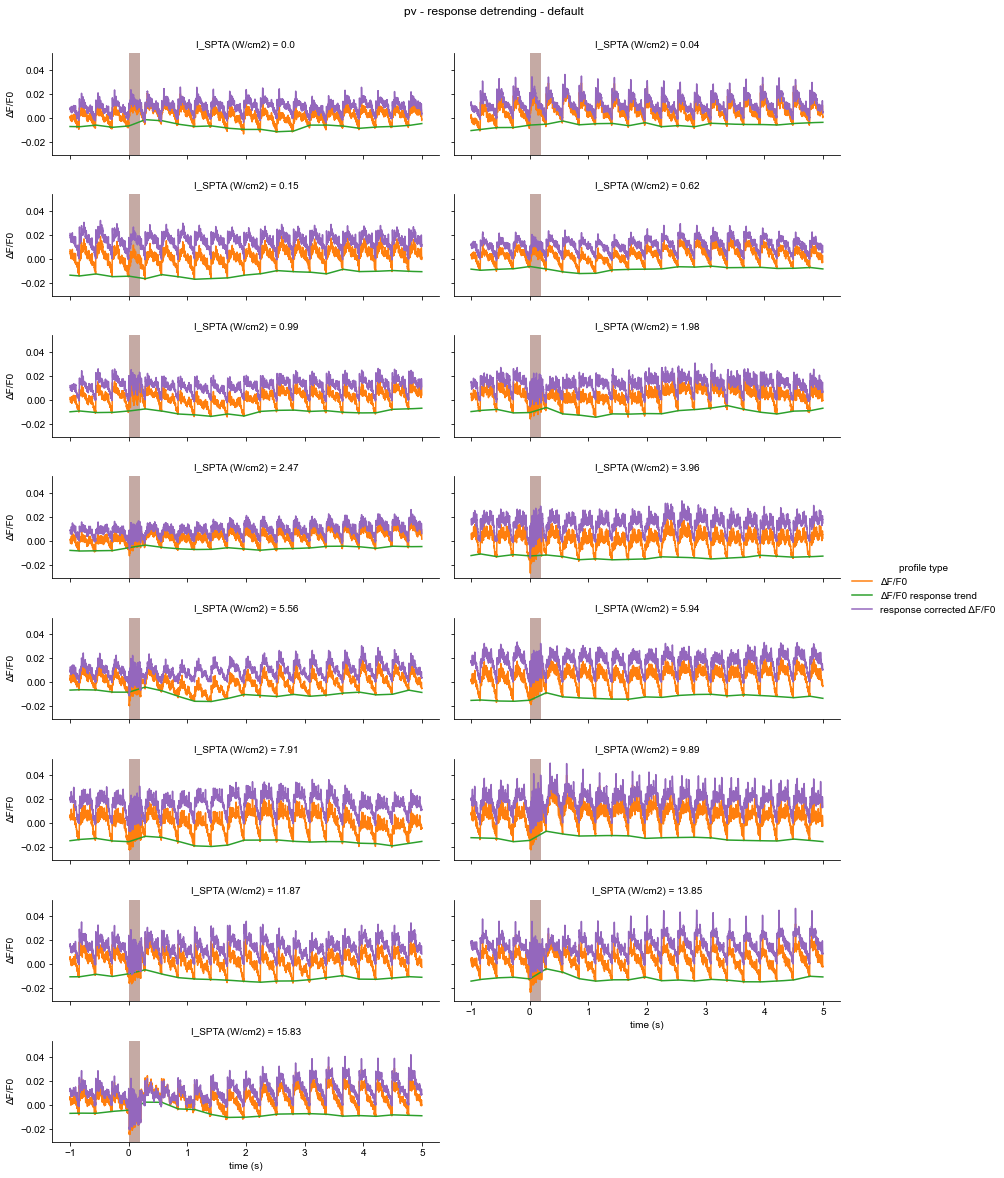

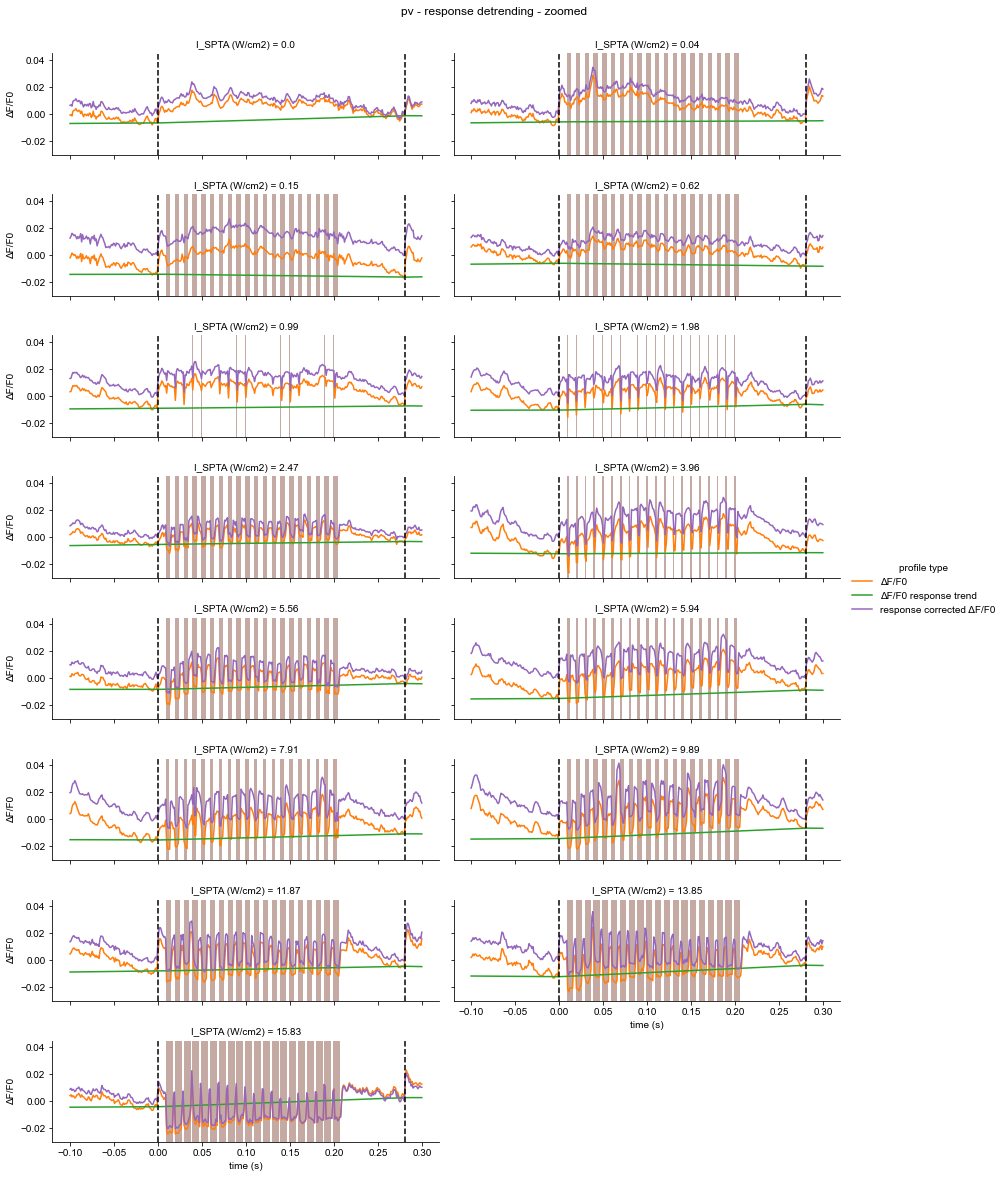

In [32]:
# Interpolate dFF values between the last row of each frame to extract "physiological response trend"
logger.info('interpolating dFF values to extract slow physiological response trend')
resp_ykey = f'{input_ykey} response trend'
trialagg_dFF[resp_ykey] = trialagg_dFF[input_ykey].copy()
trialagg_dFF.loc[trialagg_dFF.index.get_level_values(Label.ROW) != (lpf - 1), resp_ykey] = np.nan
interp_mux = get_mux_slice(trialagg_dFF.index)
interp_mux[-2:] = [0, 0]
interp_mux = tuple(interp_mux)
trialagg_dFF.loc[interp_mux, resp_ykey] = trialagg_dFF.loc[interp_mux, input_ykey]
gby = [Label.DATASET, Label.RUN]
trialagg_dFF[resp_ykey] = (
    trialagg_dFF
    .groupby(gby)
    [resp_ykey]
    .apply(lambda x: x.droplevel(gby).interpolate(method='linear'))
)

# Subtract interpolated response trend from original profile
logger.info('subtracting interpolated response trend from original profile')
resp_corrected_ykey = f'response corrected {input_ykey}'
trialagg_dFF[resp_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[resp_ykey]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - response detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, resp_ykey, resp_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = resp_corrected_ykey

### Predict and subtract expected "scanning artifact"

 2025/07/10 18:10:55: computing intra-frame variation profile (scanning artifact) from 3 preceding frames
 2025/07/10 18:10:55: averaging across cycles to get predictive "scanning artifact" profile
 2025/07/10 18:10:55: expanding "expected" scanning artifact profile along frames dimension
 2025/07/10 18:10:55: expanding (10 datasets x 15 runs x 256 rows) "response corrected ΔF/F0" series to match (10 datasets x 15 runs x 100 frames x 256 rows) reference dataframe
 2025/07/10 18:11:13: subtracting expected scanning artifact profile along trial length
 2025/07/10 18:11:13: computing cross-dataset aggregates
 2025/07/10 18:11:14: plotting ['response corrected ΔF/F0', 'expected ΔF/F0 scanning artifact', 'scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/10 18:11:18: computing cross-dataset aggregates
 2025/07/10 18:11:19: plotting ['response corrected ΔF/F0', 'expected ΔF/F0 scanning artifact', 'scanning artifact corrected ΔF/F0'] time-

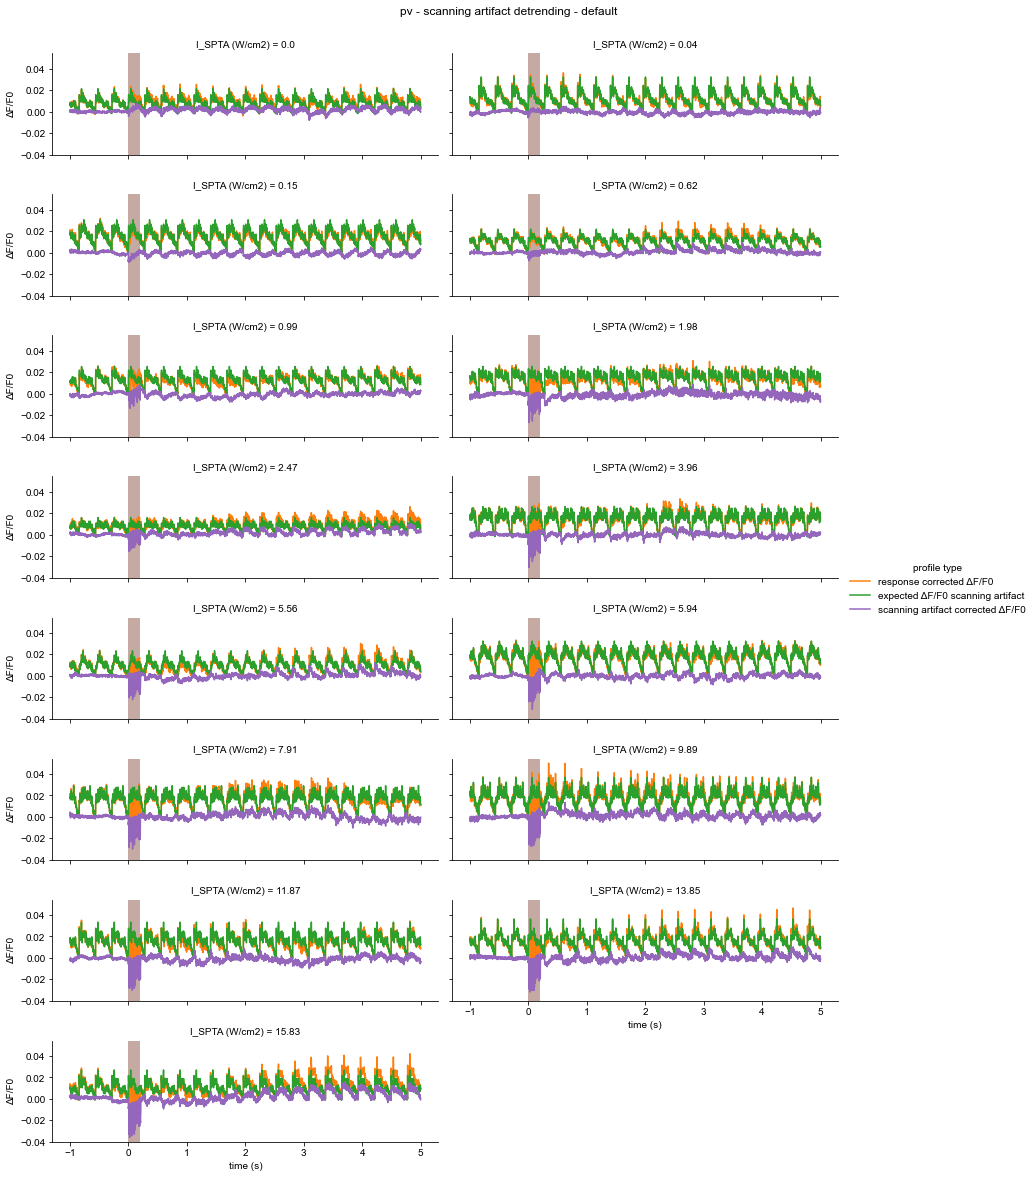

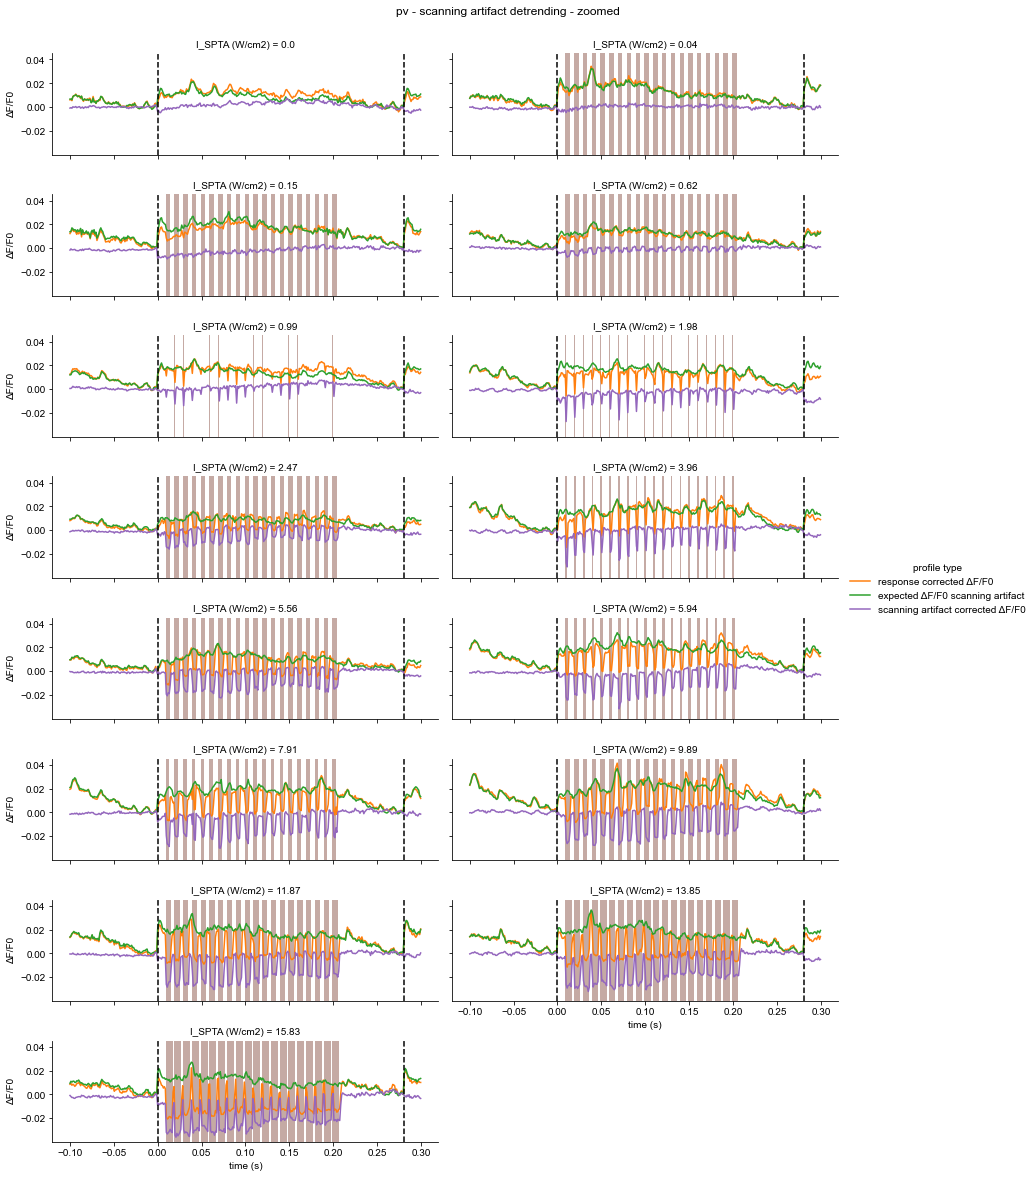

In [33]:
# Compute average intra-frame variation (scanning artifact) profile from 3 preceding frames
npre = 3
logger.info(f'computing intra-frame variation profile (scanning artifact) from {npre} preceding frames')
preceding_ibounds = np.array([-npre, -1]) + fidx.iref

# Average across cycles
logger.info('averaging across cycles to get predictive "scanning artifact" profile')
ypreavg = (trialagg_dFF
    .loc[pd.IndexSlice[:, :, preceding_ibounds[0]:preceding_ibounds[1]], input_ykey]
    .groupby([Label.DATASET, Label.RUN, Label.ROW])
    .mean()
)

# Expand average profile across frames dimension to yield "expected" scanning artifact profile
logger.info('expanding "expected" scanning artifact profile along frames dimension')
scanning_artifact_pred_key = f'expected {Label.DFF} scanning artifact'
trialagg_dFF[scanning_artifact_pred_key] = free_expand(ypreavg, trialagg_dFF)

# Subtract expected scanning artifact profile along trial length
logger.info('subtracting expected scanning artifact profile along trial length')
scanning_artifact_corrected_ykey = f'scanning artifact corrected {Label.DFF}'
trialagg_dFF[scanning_artifact_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[scanning_artifact_pred_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - scanning artifact detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, scanning_artifact_pred_key, scanning_artifact_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = scanning_artifact_corrected_ykey

### Fit and remove remaining LF baseline for each individual frame

 2025/07/10 18:11:28: applying frame-by-frame rolling filter to extract remaining intra-frame LF baseline
 2025/07/10 18:11:35: subtracting frame-by-frame baseline fit from baseline corrected profile
 2025/07/10 18:11:35: computing cross-dataset aggregates
 2025/07/10 18:11:35: plotting ['scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline fit scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/10 18:11:39: computing cross-dataset aggregates
 2025/07/10 18:11:40: plotting ['scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline fit scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


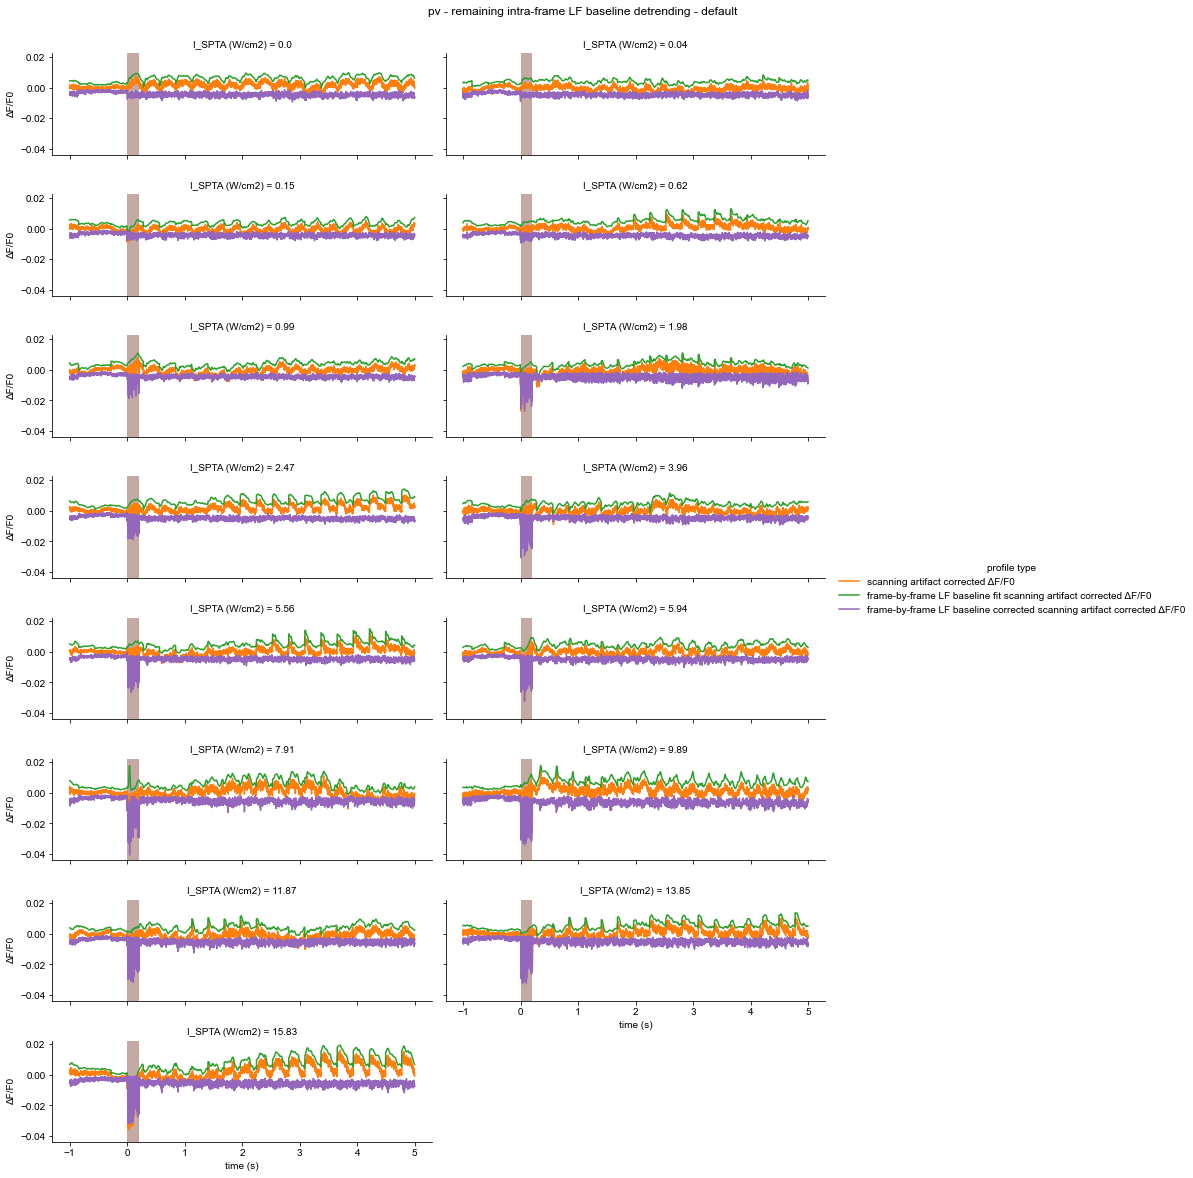

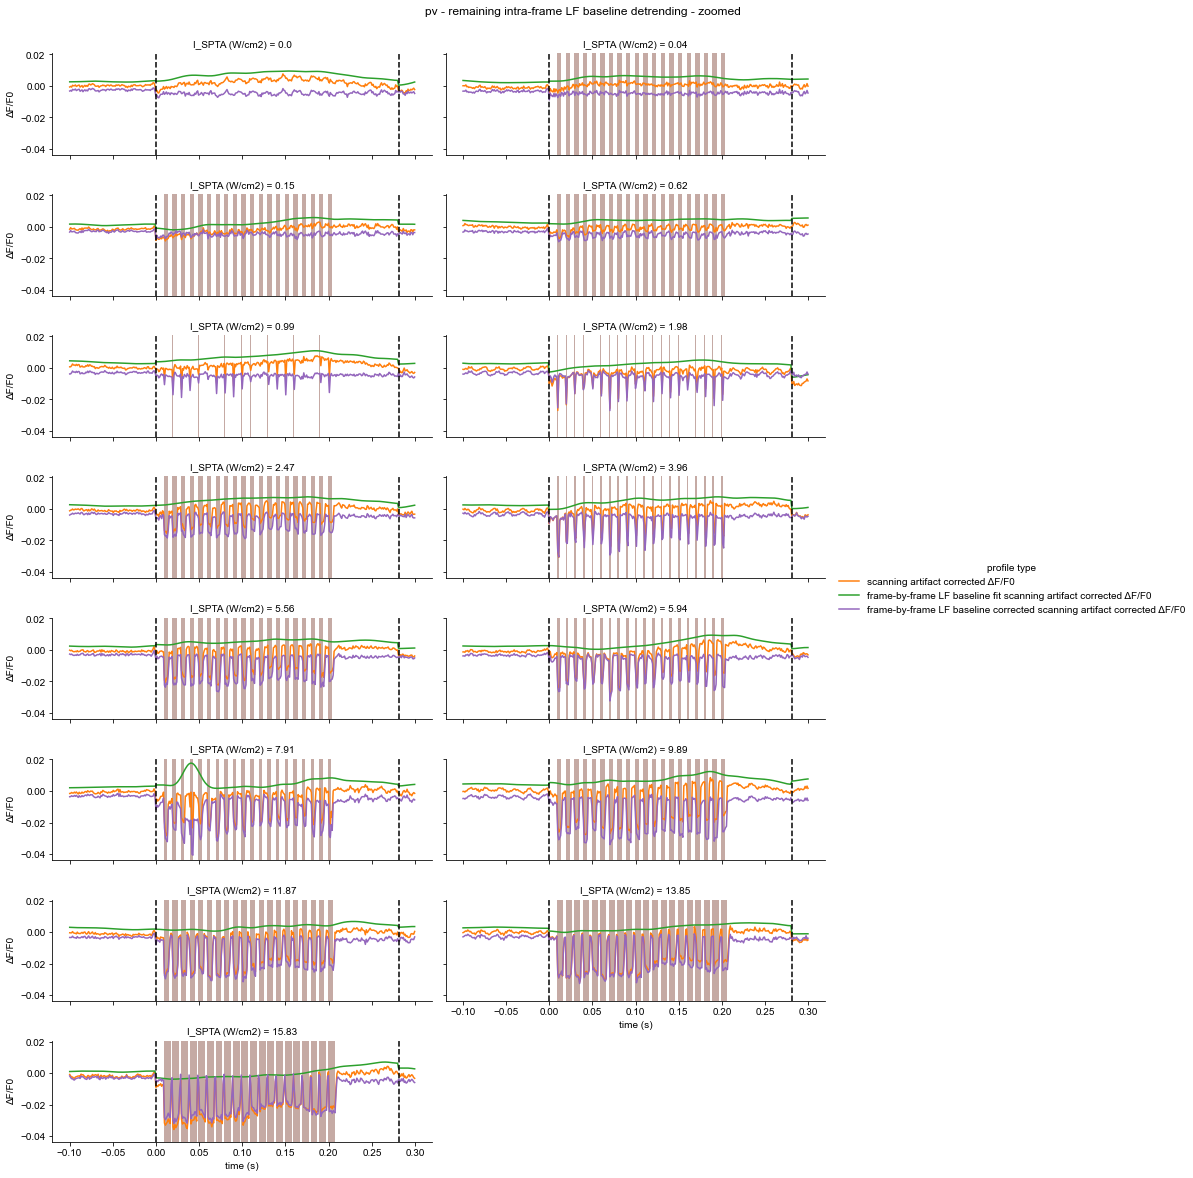

In [34]:
# Apply frame-by-frame rolling filter to extract baseline
logger.info('applying frame-by-frame rolling filter to extract remaining intra-frame LF baseline')
bfit_key = f'frame-by-frame LF baseline fit {input_ykey}'
wt = 15e-3  # Rolling window size (in s)
w = int(np.round(wt * fps * lpf))  # Rolling window size (in frames)
if w % 2 == 0:  # Ensure odd window size
    w += 1
def bfunc(y):
    return gaussian_filter1d(quantile_filter(y, w, 1), w // 2)
trialagg_dFF[bfit_key] = (trialagg_dFF
    .groupby([Label.DATASET, Label.RUN, Label.FRAME])
    [input_ykey]
    .transform(lambda y: gaussian_filter1d(quantile_filter(y.values, w, 1), w // 2))
    .values
)

# Subtract frame-by-frame baseline fit from baseline corrected profile
logger.info('subtracting frame-by-frame baseline fit from baseline corrected profile')
bcorr_key = f'frame-by-frame LF baseline corrected {input_ykey}'
trialagg_dFF[bcorr_key] = trialagg_dFF[input_ykey] - trialagg_dFF[bfit_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - remaining intra-frame LF baseline detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, bfit_key, bcorr_key],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = bcorr_key

### Plot final corrected profiles around stimulus window

 2025/07/10 18:11:48: processing intraframe fluorescence signal across ['dataset', 'run'] combinations


100%|██████████| 140/140 [00:07<00:00, 17.54it/s]


 2025/07/10 18:11:58: computing cross-dataset aggregates
 2025/07/10 18:11:59: plotting ['frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0', 'processed ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


Text(0.5, 1.02, 'pv - final corrected dFF')

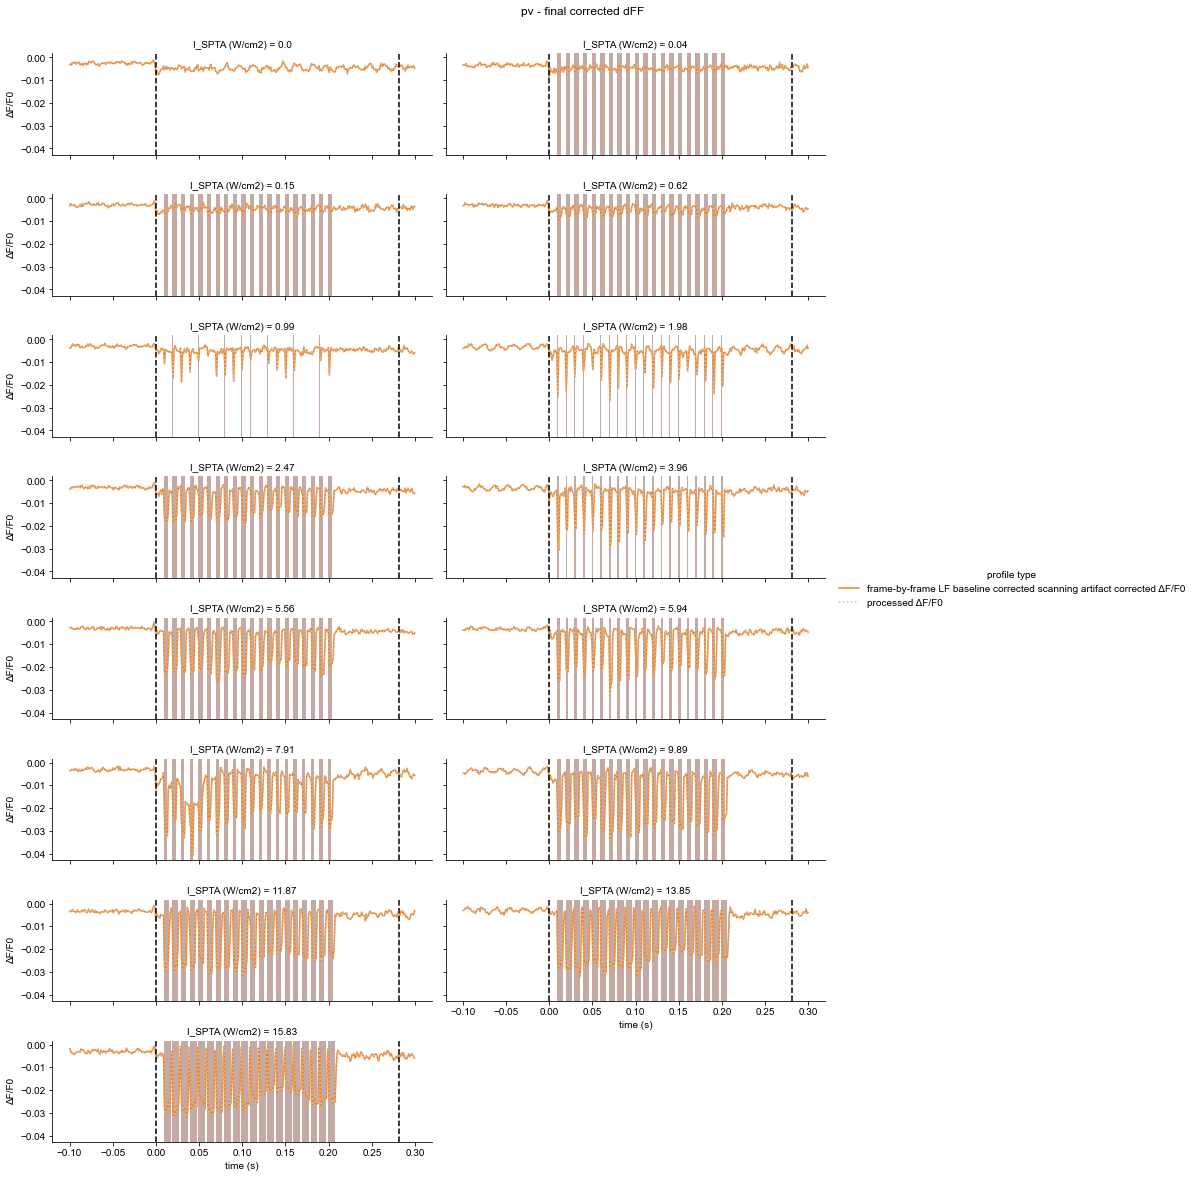

In [35]:
# Wrap entire process in 1 function
trialagg_dFF[f'processed {Label.DFF}'] = process_intraframe_fluorescence(
    trialagg_dFF[Label.DFF].copy(),
    fidx,
    fps
)

# Plot corrected signal around stimulus (comparing extended and function-wrapped processing)
title = f'{mouseline} - final corrected dFF'
figs[title] = plot_rowagg_profiles(
    aggregate_across_datasets(trialagg_dFF),
    ykey=[input_ykey, f'processed {Label.DFF}'],
    tbounds=tbounds['zoomed'],
    color=[refcolor, 'silver'],
    ls=['-', ':'],
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

### Inspect pulse-evoked dFF profiles, for each pulse and condition

 2025/07/10 18:12:05: splitting fluorescence signal by pulse across ['dataset', 'run'] combinations


100%|██████████| 140/140 [00:01<00:00, 138.68it/s]

 2025/07/10 18:12:06: expanding (10 datasets x 15 runs) input dataframe to match (10 datasets x 15 runs x 20 pulses x 182 time w.r.t pulse onset (ms)s) reference dataframe


 2025/07/10 18:12:06: plotting single pulse dFF profiles
 2025/07/10 18:12:06: computing cross-dataset aggregates


Text(0.5, 1.02, 'pv - pulse-evoked dFF across pulse train')

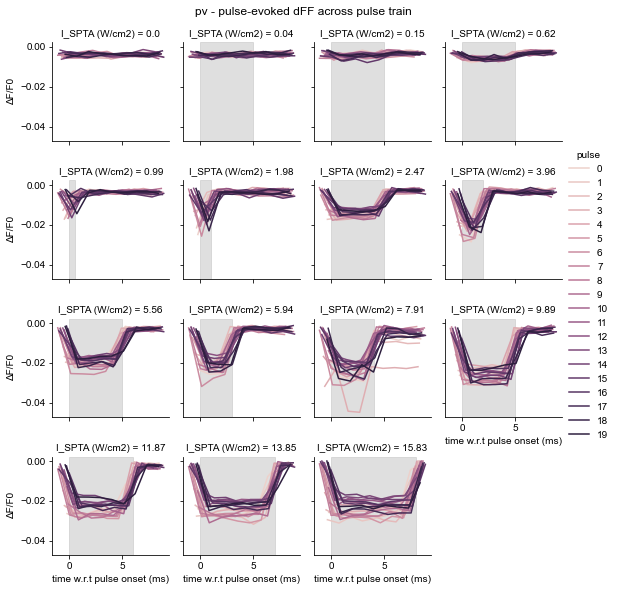

In [36]:
ykey = f'processed {Label.DFF}'

# Extract pulse-by-pulse dFF
dFF_by_pulse = split_by_pulse(
    trialagg_dFF[ykey], fidx, fps, dur, PRF, onset=STIM_TRIG_DELAY) 
dFF_by_pulse = free_expand_and_add(info_table[exp_keys], dFF_by_pulse.to_frame())

# Plot "single pulse" dFF profiles
logger.info('plotting single pulse dFF profiles')
g = sns.relplot(
    kind='line',
    data=aggregate_across_datasets(dFF_by_pulse),
    x=Label.PULSERELTIME,
    y=ykey,
    hue=Label.PULSE,
    col=group_key,
    col_wrap=4,
    height=2,
    legend='full',
)
g.set_axis_labels(Label.PULSERELTIME, Label.DFF)

# Add shaded areas for pulses
for colval, ax in g.axes_dict.items():
    DC = col_DC_map.loc[colval]
    if DC > 0:
        PD = (DC * 1e-2) / PRF * 1e3  # ms
        tpulse = np.array([0, PD])
        ax.axvspan(*tpulse, color='silver', alpha=0.5)  # shaded area for pulse duration

title = f'{mouseline} - pulse-evoked dFF across pulse train'
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Harmonize relative time vectors and inspect average pulse-evoked dFF profiles

 2025/07/10 18:12:11: harmonizing pulse-relative time vectors...
 2025/07/10 18:12:13: plotting single pulse dFF profiles (interpolated)
 2025/07/10 18:12:13: computing cross-dataset aggregates


Text(0.5, 1.02, 'pv - average pulse-evoked dFF')

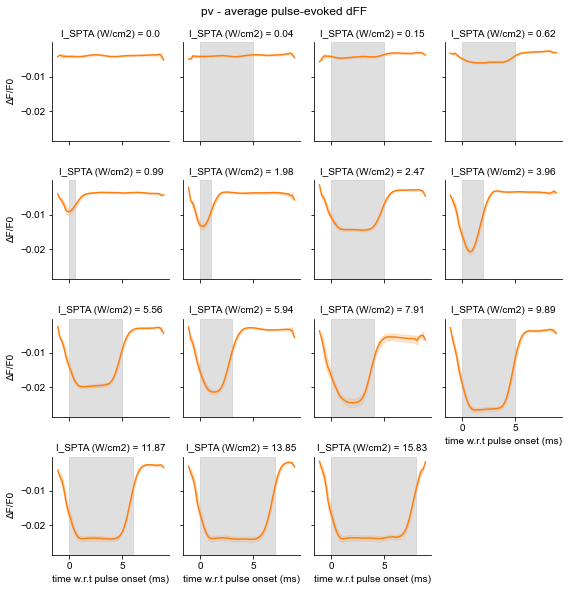

In [37]:
logger.info('harmonizing pulse-relative time vectors...')
# Identify all relative time values
reltimes = dFF_by_pulse.index.get_level_values(Label.PULSERELTIME)
smooth_reltimes = np.linspace(reltimes.min(), reltimes.max(), 50)

# Interpolate dFF values at smooth_reltimes for each dataset, run, and pulse
def interpfunc(df):
    return pd.Series(
        np.interp(smooth_reltimes, df.index.get_level_values(Label.PULSERELTIME), df[ykey], left=np.nan, right=np.nan), 
        index=pd.Index(smooth_reltimes, name=Label.PULSERELTIME), name=ykey)
gby = [k for k in dFF_by_pulse.index.names if k != Label.PULSERELTIME]
exp_dFF_by_pulse = (dFF_by_pulse
    .groupby(gby)
    .apply(interpfunc)
    .stack()
    .rename(ykey)
    .to_frame()
)

# Add relevant columns to expanded trial-aggregated dFF
for key in exp_keys:
    exp_dFF_by_pulse[key] = dFF_by_pulse[key].groupby(gby).first()

# Plot "single pulse" dFF profiles
logger.info('plotting single pulse dFF profiles (interpolated)')
g = sns.relplot(
    kind='line',
    data=aggregate_across_datasets(exp_dFF_by_pulse),
    x=Label.PULSERELTIME,
    y=ykey,
    color=refcolor,
    errorbar='se',
    col=group_key,
    col_wrap=4,
    height=2,
    legend='full',
)
g.set_axis_labels(Label.PULSERELTIME, Label.DFF)

# Add shaded areas for pulses
for colval, ax in g.axes_dict.items():
    DC = col_DC_map.loc[colval]
    if DC > 0:
        PD = (DC * 1e-2) / PRF * 1e3  # ms
        tpulse = np.array([0, PD])
        ax.axvspan(*tpulse, color='silver', alpha=0.5)  # shaded area for pulse duration

title = f'{mouseline} - average pulse-evoked dFF'
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Quantify pulse-evoked dFF dip and its dependence on parameters and pulse index

In [38]:
dFF_by_pulse

processed ΔF/F0  \
dataset                 run pulse time w.r.t pulse onset (ms)                    
20190606_mouse2_region1 0   0     -0.221910                           0.000000   
                                   0.875351                          -0.032858   
                                   1.972612                          -0.031053   
                                   3.069874                          -0.025005   
                                   4.167135                          -0.024817   
...                                                                        ...   
20190821_mouse7_region1 14  19     3.993329                          -0.053975   
                                   5.090590                          -0.050413   
                                   6.187851                          -0.042237   
                                   7.285112                          -0.036728   
                                   8.382374                          -0.016671   

                                                               P (MPa)  \
dataset                 run pulse time w.r.t pulse onset (ms)            
20190606_mouse2_region1 0   0     -0.221910                        0.8   
                                   0.875351                        0.8   
                                   1.972612                        0.8   
                                   3.069874                        0.8   
                                   4.167135                        0.8   
...                                                                ...   
20190821_mouse7_region1 14  19     3.993329                        0.8   
                                   5.090590                        0.8   
                                   6.187851                        0.8   
                                   7.285112                        0.8   
                                   8.382374                        0.8   

                                                               DC (%)  \
dataset                 run pulse time w.r.t pulse onset (ms)           
20190606_mouse2_region1 0   0     -0.221910                      50.0   
                                   0.875351                      50.0   
                                   1.972612                      50.0   
                                   3.069874                      50.0   
                                   4.167135                      50.0   
...                                                               ...   
20190821_mouse7_region1 14  19     3.993329                      80.0   
                                   5.090590                      80.0   
                                   6.187851                      80.0   
                                   7.285112                      80.0   
                                   8.382374                      80.0   

                                                               I_SPPA (W/cm2)  \
dataset                 run pulse time w.r.t pulse onset (ms)                   
20190606_mouse2_region1 0   0     -0.221910                             19.78   
                                   0.875351                             19.78   
                                   1.972612                             19.78   
                                   3.069874                             19.78   
                                   4.167135                             19.78   
...                                                                       ...   
20190821_mouse7_region1 14  19     3.993329                             19.78   
                                   5.090590                             19.78   
                                   6.187851                             19.78   
                                   7.285112                             19.78   
                                   8.382374                             19.78   

                             

 2025/07/10 18:12:16: computing pulse-evoked dFF dip
 2025/07/10 18:12:16: extracting "noise dip" for reference condition
 2025/07/10 18:12:16: plotting average pulse-evoked dFF dip vs P, ISPPA and DC
 2025/07/10 18:12:17: computing relative dip per pulse w.r.t first one
 2025/07/10 18:12:17: plotting relative change in pulse-evoked dFF dip


Text(0.5, 1.02, 'pv - relative change in pulse-evoked dFF dip')

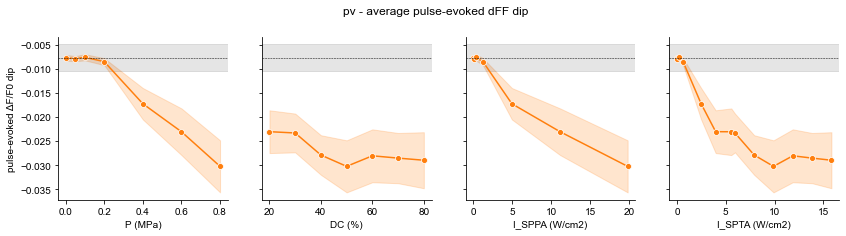

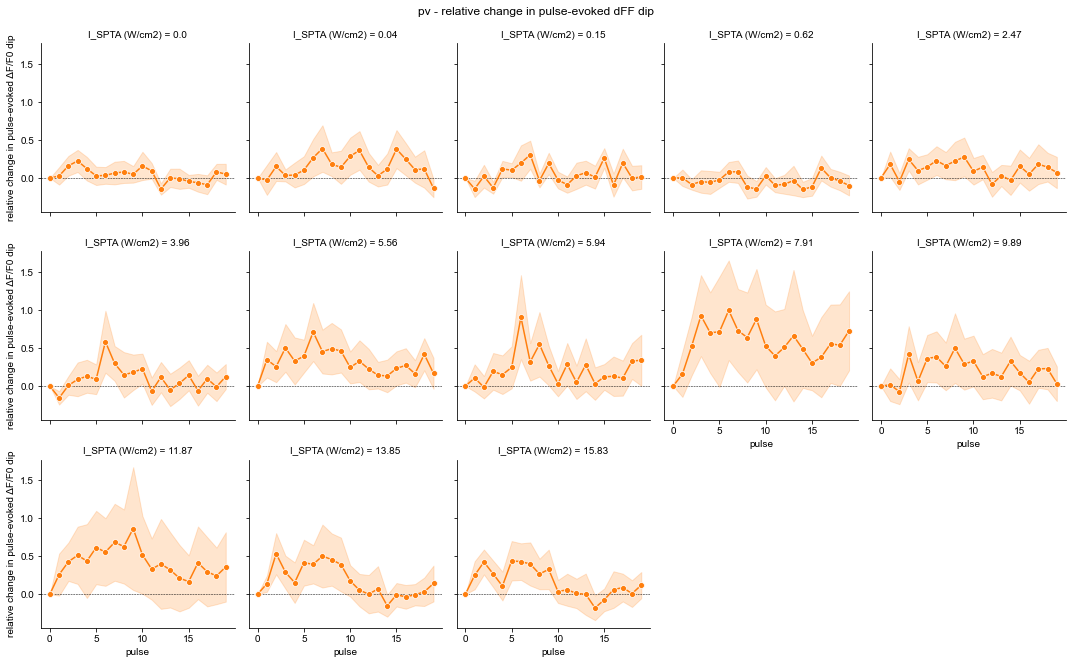

In [39]:
# Compute pulse-evoked dFF dip, along with P, DC, ISPPA, and grouping variable
logger.info('computing pulse-evoked dFF dip')
dip_ykey = f'pulse-evoked {Label.DFF} dip'
pulse_stats = (
    dFF_by_pulse
    .groupby([k for k in dFF_by_pulse.index.names if k != Label.PULSERELTIME])
    .agg({
        ykey: lambda x: -np.ptp(x),
        **{k: 'first' for k in exp_keys},
    })
    .rename(columns={ykey: dip_ykey})
)

# Extract "noise dip" for reference condition
logger.info('extracting "noise dip" for reference condition')
noisedip = pulse_stats[pulse_stats[group_key] == group_refval][dip_ykey]

# For main analysis, restrict to DC >= 20% to avoid sub-sampled dips at low DCs
if group_key == Label.ISPTA:
    pulse_stats = pulse_stats[pulse_stats[Label.DC] >= 20.]

# Average across pulses for each column grouping value and dataset
aggfuncs = {k: 'mean' if k == dip_ykey else 'first' for k in pulse_stats.columns}
pulseavg_stats = (
    pulse_stats
    .groupby([Label.DATASET, Label.RUN])
    .agg(aggfuncs)
)

# Plot average pulse-evoked dip vs P, ISPPA and DC
logger.info('plotting average pulse-evoked dFF dip vs P, ISPPA and DC')
title = f'{mouseline} - average pulse-evoked dFF dip'
xkeys = exp_keys if group_key == Label.ISPTA else [group_key]
figs[title], axes = plt.subplots(1, len(xkeys), figsize=(3.5 * len(xkeys), 3), sharey=True)
axes = np.atleast_1d(axes)  # Ensure axes is always an array
figs[title].suptitle(title, y=1.02)
for ax, xkey in zip(axes, xkeys):
    if xkey == Label.DC:
        pltdata = pulseavg_stats[pulseavg_stats[Label.P] == P_REF] 
    elif xkey in (Label.P, Label.ISPPA):
        pltdata = pulseavg_stats[pulseavg_stats[Label.DC] == DC_REF]
    else:
        pltdata = pulseavg_stats.copy()
    for kwargs in [
            # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
            dict(marker='o', errorbar='se')
        ]:
        sns.lineplot(
            ax=ax,
            data=pltdata,
            x=xkey,
            y=dip_ykey,
            color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
            legend=ax is axes[-1],
            **kwargs,
        )
    sns.despine(ax=ax)
    ax.axhline(noisedip.mean(), color='k', linestyle='--', linewidth=0.5, label='noise dip')
    ax.axhspan(noisedip.mean() - noisedip.std(), noisedip.mean() + noisedip.std(), color='k', alpha=0.1)

# Compute relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('computing relative dip per pulse w.r.t first one')
rel_dip_ykey = f'relative change in {dip_ykey}'
refdips = pulse_stats.loc[pd.IndexSlice[:, :, 0], dip_ykey].droplevel(Label.PULSE)
pulse_stats[rel_dip_ykey] = (pulse_stats[dip_ykey] - refdips) / refdips

# Plot relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('plotting relative change in pulse-evoked dFF dip')
title = f'{mouseline} - relative change in pulse-evoked dFF dip'
g = sns.FacetGrid(
    data=pulse_stats.reset_index(),
    col=group_key,
    col_wrap=5,
    height=3,
)
for ax in g.axes_dict.values():
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
for kwargs in [
        # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
        dict(marker='o', errorbar='se')
    ]:
    g.map_dataframe(
        sns.lineplot,
        x=Label.PULSE,
        y=rel_dip_ykey,
        color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
        **kwargs
    )
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Save figures

In [40]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=f'intraframe_{mouseline}_{analysis_type}_analysis')

 2025/07/10 18:12:20: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2025.07.10/figs_intraframe_pv_main_analysis.pdf:


100%|██████████| 15/15 [00:22<00:00,  1.49s/it]


### Notify upon completion

In [41]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'intra-pulse analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/07/10 18:12:43: intra-pulse analysis notebook completed in 0:03:15.882098 s
